## Analysis of Osmotic Stress RNA-seq data

This document is a reproducible record of the various steps in the analysis of osmotic stress RNA-seq data for RPE-1 cells.

### Necessary Modules and R Packages

Apart from `r-base` and `r-essentials` set of packages the following sets of additional packages are necessary.

- NMF
- ggplot2
- locfit (there may be some complexities in anaconda install)

From [Bioconductor](https://bioconductor.org) the following are needed (installed with `BiocManager::install()`)

- DESeq2
- limma
- vsn
- gplots

### Load relevant libraries

First we will load the necessary libraries as below

In [1]:
Libraries <- c("limma","vsn","gplots","ggplot2","DESeq2","stringr")
suppressMessages(lapply(Libraries, require, character.only=T))

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

### Loading Count Data

Next we will load the count data from the tab separated file as below and inspect it. Then we will rename the rows based on gene ID.

In [2]:
read.counts <- read.table("gene_expression_organized_2.txt", sep = "", header = T)
head(read.counts)

st_gene_id,gene_id,gene_symbol,read_count_Media_0h_1,read_count_Media_0h_2,read_count_Media_0h_3,read_count_Media_6h_1,read_count_Media_6h_2,read_count_Media_6h_3,read_count_Media_12h_1,...,read_count_Hyper_12h_3,read_count_Hyper_24h_1,read_count_Hyper_24h_2,read_count_Hyper_24h_3,read_count_Hyper_48h_1,read_count_Hyper_48h_2,read_count_Hyper_48h_3,read_count_Hyper_72h_1,read_count_Hyper_72h_2,read_count_Hyper_72h_3
G9606_9266,2323,FLT3LG,273,292.0,221,218,207,219,267,...,276,350,307,298,244,342,235,291,260.00,325
G9606_9392,90459,ERI1,535,611.0,520,590,539,526,570,...,401,507,486,378,507,425,511,339,366.00,334
G9606_4009,79595,SAP130,3580,4097.0,3234,3931,4068,3823,4216,...,3136,3152,3098,2977,3611,3324,3384,2956,2775.00,2763
G9606_24999,100129098,LOC100129098,0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0
G9606_4181,10927,SPIN1,1809,1690.0,1607,2423,1866,1927,2343,...,2636,2022,1906,1731,2707,2232,2312,2084,2193.00,1778
G9606_16727,8879,SGPL1,1619,1526.1,1642,1636,1613,1526,1719,...,1911,1634,1604,1450,1779,1359,1418,1634,1480.99,1519


In [3]:
read.counts <- read.counts[!duplicated(read.counts$gene_symbol),]

In [4]:
row.names(read.counts) <- read.counts$gene_symbol
Genenames <- read.counts$gene_symbol

Next we will delete the non-numeric data after saving the gene symbols in a separate vector as we will need it later

In [5]:
read.counts <- read.counts[,-c(1:3)]
head(read.counts)

,read_count_Media_0h_1,read_count_Media_0h_2,read_count_Media_0h_3,read_count_Media_6h_1,read_count_Media_6h_2,read_count_Media_6h_3,read_count_Media_12h_1,read_count_Media_12h_2,read_count_Media_12h_3,read_count_Media_24h_1,...,read_count_Hyper_12h_3,read_count_Hyper_24h_1,read_count_Hyper_24h_2,read_count_Hyper_24h_3,read_count_Hyper_48h_1,read_count_Hyper_48h_2,read_count_Hyper_48h_3,read_count_Hyper_72h_1,read_count_Hyper_72h_2,read_count_Hyper_72h_3
FLT3LG,273,292.0,221,218,207,219,267,207,206,233,...,276,350,307,298,244,342,235,291,260.00,325
ERI1,535,611.0,520,590,539,526,570,474,531,577,...,401,507,486,378,507,425,511,339,366.00,334
SAP130,3580,4097.0,3234,3931,4068,3823,4216,4030,3418,3635,...,3136,3152,3098,2977,3611,3324,3384,2956,2775.00,2763
LOC100129098,0,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0
SPIN1,1809,1690.0,1607,2423,1866,1927,2343,2001,1988,2393,...,2636,2022,1906,1731,2707,2232,2312,2084,2193.00,1778
SGPL1,1619,1526.1,1642,1636,1613,1526,1719,1493,1579,1422,...,1911,1634,1604,1450,1779,1359,1418,1634,1480.99,1519


### Preparation for DESeq Analysis

Next we have to prepare the data for analysis using `DESeq2`. For this first we have to modify the names of the columns and create a factor vector from the column names

In [6]:
read.counts.orig.names <- names(read.counts)
names(read.counts) <- gsub("read_count_(.*)", "\\1", read.counts.orig.names)
names(read.counts)[1:5]

[1] "Media_0h_1" "Media_0h_2" "Media_0h_3" "Media_6h_1" "Media_6h_2"

In [7]:
sample_info <- data.frame(condition = gsub("([A-Za-z]+)_.*", "\\1", names(read.counts)), row.names = names(read.counts))
sample_info[1:5,]

[1] Media Media Media Media Media
Levels: Hyper Hypo Iso Media

In [8]:
#Time information
time_info <- data.frame(condition = gsub("[A-Za-z]+_([0-9]+h)_[0-9]", "\\1", names(read.counts)), row.names = names(read.counts))
time_info[1:5,]

[1] 0h 0h 0h 6h 6h
Levels: 0h 12h 24h 48h 6h 72h

### Import Data to DESeq2 and inspect

Next we are ready to import the data using DESeq2 and inspect to make sure that the import is successful.

In [9]:
DESeq.ds <- DESeqDataSetFromMatrix(countData=round(read.counts), colData=sample_info, design = ~ condition)
head(colData(DESeq.ds))
head(rowData(DESeq.ds))
head(assay(DESeq.ds, "counts"))

converting counts to integer mode


DataFrame with 6 rows and 1 column
           condition
            <factor>
Media_0h_1     Media
Media_0h_2     Media
Media_0h_3     Media
Media_6h_1     Media
Media_6h_2     Media
Media_6h_3     Media

DataFrame with 6 rows and 0 columns

,Media_0h_1,Media_0h_2,Media_0h_3,Media_6h_1,Media_6h_2,Media_6h_3,Media_12h_1,Media_12h_2,Media_12h_3,Media_24h_1,...,Hyper_12h_3,Hyper_24h_1,Hyper_24h_2,Hyper_24h_3,Hyper_48h_1,Hyper_48h_2,Hyper_48h_3,Hyper_72h_1,Hyper_72h_2,Hyper_72h_3
FLT3LG,273,292,221,218,207,219,267,207,206,233,...,276,350,307,298,244,342,235,291,260,325
ERI1,535,611,520,590,539,526,570,474,531,577,...,401,507,486,378,507,425,511,339,366,334
SAP130,3580,4097,3234,3931,4068,3823,4216,4030,3418,3635,...,3136,3152,3098,2977,3611,3324,3384,2956,2775,2763
LOC100129098,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SPIN1,1809,1690,1607,2423,1866,1927,2343,2001,1988,2393,...,2636,2022,1906,1731,2707,2232,2312,2084,2193,1778
SGPL1,1619,1526,1642,1636,1613,1526,1719,1493,1579,1422,...,1911,1634,1604,1450,1779,1359,1418,1634,1481,1519


### Collapsing technical replicates

Since there are three technical replicates for each different sample we will use the `collapseReplicates()` function in DESeq2 to collapse them and verify that the transformation was correct

In [10]:
Bio_Factors <- factor(gsub("([a-zA-z]+_[0-9]+h)_[0-9]", "\\1", colnames(DESeq.ds)))
Bio_Factors

[1] Media_0h  Media_0h  Media_0h  Media_6h  Media_6h  Media_6h  Media_12h
 [8] Media_12h Media_12h Media_24h Media_24h Media_24h Media_48h Media_48h
[15] Media_48h Media_72h Media_72h Media_72h Iso_6h    Iso_6h    Iso_6h   
[22] Iso_12h   Iso_12h   Iso_12h   Iso_24h   Iso_24h   Iso_24h   Iso_48h  
[29] Iso_48h   Iso_48h   Iso_72h   Iso_72h   Iso_72h   Hypo_6h   Hypo_6h  
[36] Hypo_6h   Hypo_12h  Hypo_12h  Hypo_12h  Hypo_24h  Hypo_24h  Hypo_24h 
[43] Hypo_48h  Hypo_48h  Hypo_48h  Hypo_72h  Hypo_72h  Hypo_72h  Hyper_6h 
[50] Hyper_6h  Hyper_6h  Hyper_12h Hyper_12h Hyper_12h Hyper_24h Hyper_24h
[57] Hyper_24h Hyper_48h Hyper_48h Hyper_48h Hyper_72h Hyper_72h Hyper_72h
21 Levels: Hyper_12h Hyper_24h Hyper_48h Hyper_6h Hyper_72h ... Media_72h

In [11]:
DESeq.ds.coll <- collapseReplicates(DESeq.ds, Bio_Factors)
colData(DESeq.ds.coll)
head(assay(DESeq.ds.coll, "counts"))

DataFrame with 21 rows and 1 column
          condition
           <factor>
Hyper_12h     Hyper
Hyper_24h     Hyper
Hyper_48h     Hyper
Hyper_6h      Hyper
Hyper_72h     Hyper
...             ...
Media_12h     Media
Media_24h     Media
Media_48h     Media
Media_6h      Media
Media_72h     Media

,Hyper_12h,Hyper_24h,Hyper_48h,Hyper_6h,Hyper_72h,Hypo_12h,Hypo_24h,Hypo_48h,Hypo_6h,Hypo_72h,...,Iso_24h,Iso_48h,Iso_6h,Iso_72h,Media_0h,Media_12h,Media_24h,Media_48h,Media_6h,Media_72h
FLT3LG,952,955,821,390,876,772,878,922,698,862,...,820,821,783,934,786,680,622,773,644,989
ERI1,1276,1371,1443,1378,1039,1288,1095,826,1530,928,...,1534,1309,1577,1111,1666,1575,1797,1702,1655,1093
SAP130,10041,9227,10319,12369,8494,11424,6901,5640,9221,5322,...,9216,8926,10466,7131,10911,11664,10125,10269,11822,7312
LOC100129098,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
SPIN1,7867,5659,7251,7649,6055,6487,5447,4471,5436,4698,...,6265,5809,5676,5740,5106,6332,6694,6616,6216,5662
SGPL1,5341,4688,4556,3729,4634,8625,5603,4819,6731,5894,...,4573,4146,4873,4519,4787,4791,4412,3941,4775,4427


In [12]:
time_info.coll <- data.frame(condition = gsub("[A-Za-z]+_([0-9]+h)", "\\1", colnames(DESeq.ds.coll)), row.names = colnames(DESeq.ds.coll))
time_info.coll[1:5,]

[1] 12h 24h 48h 6h  72h
Levels: 0h 12h 24h 48h 6h 72h

In [13]:
DESeq.ds.coll <- DESeq.ds.coll
colData(DESeq.ds.coll) <- cbind(colData(DESeq.ds.coll), time_info.coll)
colData(DESeq.ds.coll)

DataFrame with 21 rows and 2 columns
          condition condition
           <factor>  <factor>
Hyper_12h     Hyper       12h
Hyper_24h     Hyper       24h
Hyper_48h     Hyper       48h
Hyper_6h      Hyper        6h
Hyper_72h     Hyper       72h
...             ...       ...
Media_12h     Media       12h
Media_24h     Media       24h
Media_48h     Media       48h
Media_6h      Media        6h
Media_72h     Media       72h

### Normalization of counts

Next is the important step of normalization of counts. To do this we will first remove any gene with zero counts and then check to make sure that column counts are consistent.

In [14]:
DESeq.ds.coll <- DESeq.ds.coll[ rowSums(counts(DESeq.ds.coll)) > 0, ]
DESeq.ds.coll <- na.omit(DESeq.ds.coll)
colSums(counts(DESeq.ds.coll))[1:5]

Hyper_12h Hyper_24h Hyper_48h  Hyper_6h Hyper_72h 
 76776790  79798273  78977730  76210729  76982339

To perform the normalization we will first use `estimateSizeFactors` from DESeq2 and then use `counts()` to normalize it. Finally we will do a log2 transform

In [15]:
DESeq.ds.coll <- estimateSizeFactors(DESeq.ds.coll)
counts.coll.sf_normalized <- counts(DESeq.ds.coll, normalized=T)
log.norm.counts.coll <- log2(counts.coll.sf_normalized + 1)

Next we can visualize the unnormalized and normalized data to make sure that normalization was done properly

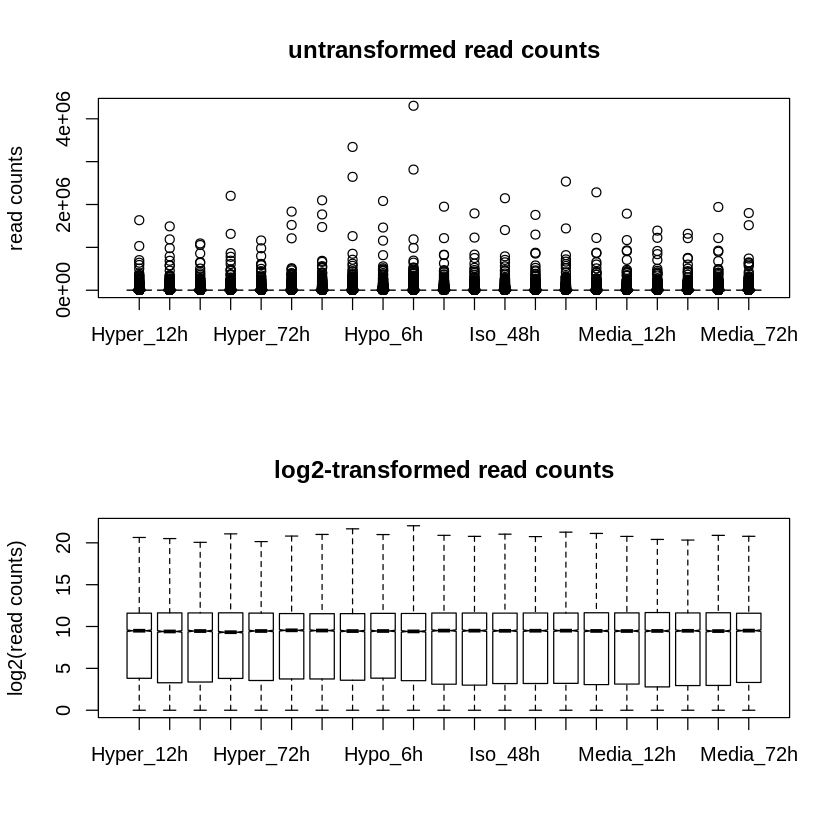

In [16]:
par(mfrow=c(2,1))
boxplot(counts.coll.sf_normalized, notch=T, main="untransformed read counts", ylab="read counts")
boxplot(log.norm.counts.coll, notch=T, main="log2-transformed read counts", ylab="log2(read counts)")

### Visual Exploration and Homoskedasticity Test

Next we will explore the data visually by doing pairwise plots to make sure the read counts are similar between replicates. Also we will do a `meanSdplot()` to check the homoskedasticity of the data (i.e. all variables have similar variance)

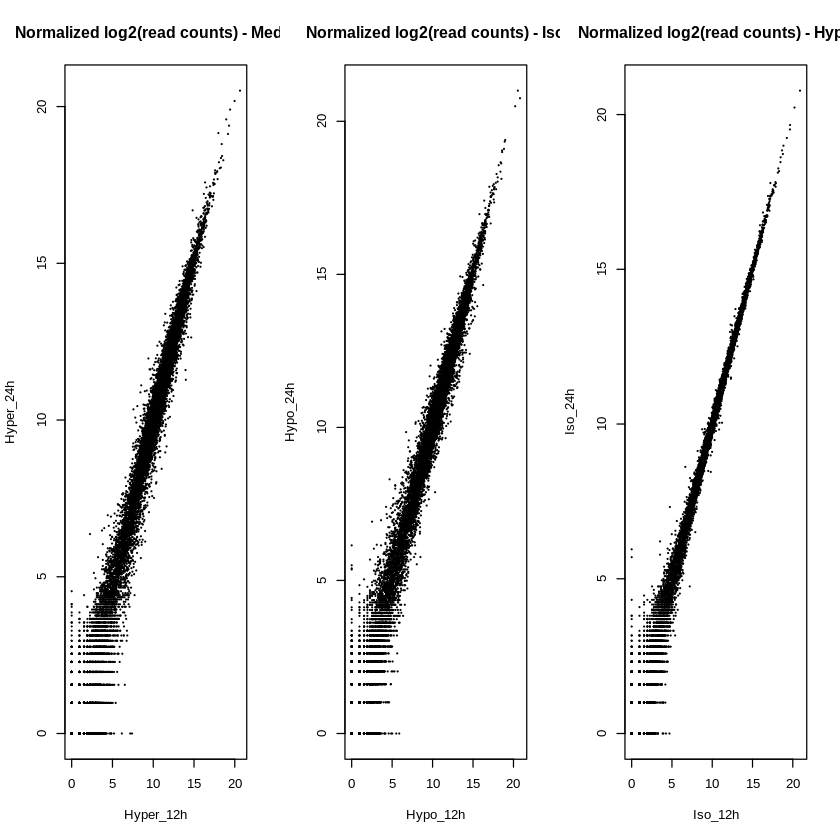

In [17]:
par(mfrow = c(1,3))
plot(log.norm.counts.coll[,1:2], cex=.1, main = "Normalized log2(read counts) - Media")
plot(log.norm.counts.coll[,6:7], cex=.1, main = "Normalized log2(read counts) - Iso")
plot(log.norm.counts.coll[,11:12], cex=.1, main = "Normalized log2(read counts) - Hypo")

Next we can plot the `meanSdplot()` as below with `ggplot2`

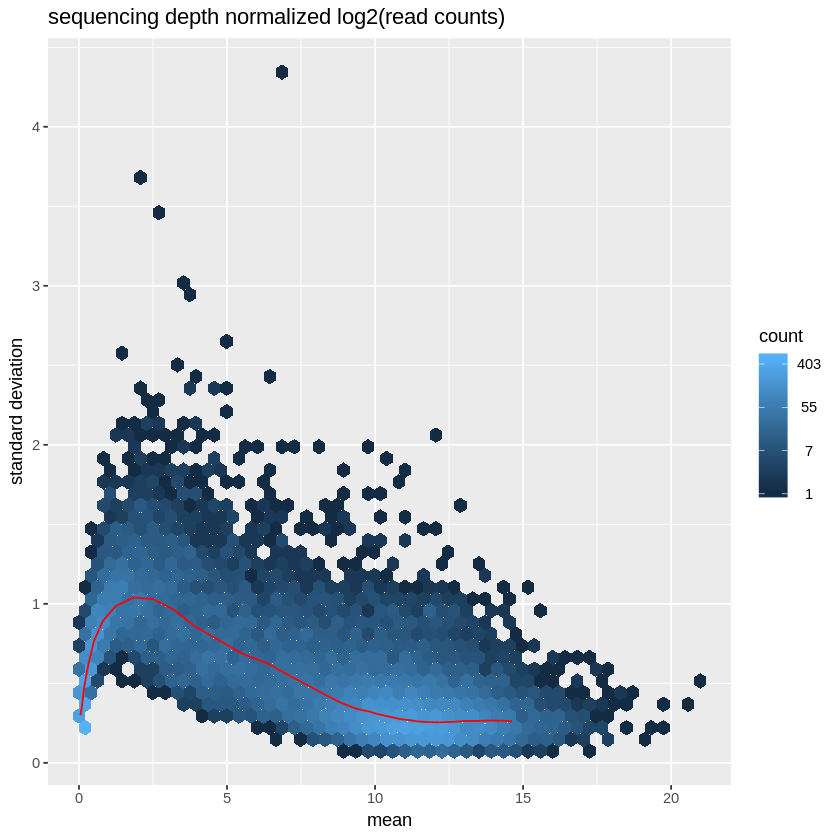

In [18]:
msd_plot.coll <- meanSdPlot(log.norm.counts.coll, ranks=F, plot=F)
msd_plot.coll$gg + ggtitle("sequencing depth normalized log2(read counts)") + ylab("standard deviation")

### Decreasing heteroskedasticity

As we can see from the plot above the counts are indeed very heteroskedastic. The `rlog()` function in DESeq2 returns values that are both normalized for sequencing depth and transformed to log scale. So we can use this for our purpose.

In [19]:
DESeq.rlog.coll <- rlog(DESeq.ds.coll, blind=T)
rlog.norm.counts.coll <- assay(DESeq.rlog.coll)

In [20]:
colnames(colData(DESeq.rlog.coll))[1] <- "Treatment"
colnames(colData(DESeq.rlog.coll))[2] <- "Time"

Now we can plot the meanSdplot as before and compare with the previous data

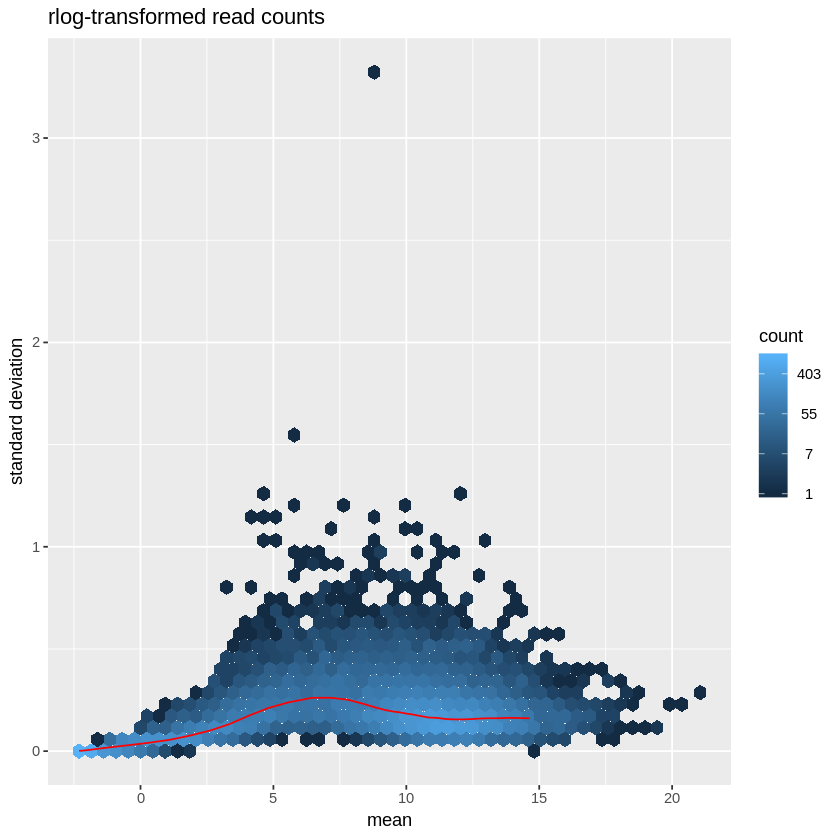

In [21]:
msd_plot2.coll <- meanSdPlot(rlog.norm.counts.coll, ranks=F, plot=F)
msd_plot2.coll$gg + ggtitle("rlog-transformed read counts") + ylab("standard deviation")

We can see from the plot above that the above operations have reduced heteroskedasticity of data. So we will now use this transformed data for our analysis.

### Correlation Analysis and Clustering

Next we can do a simple correlation analysis and generate simple cluster diagram to identify any association between the mediums of different osmolarities.

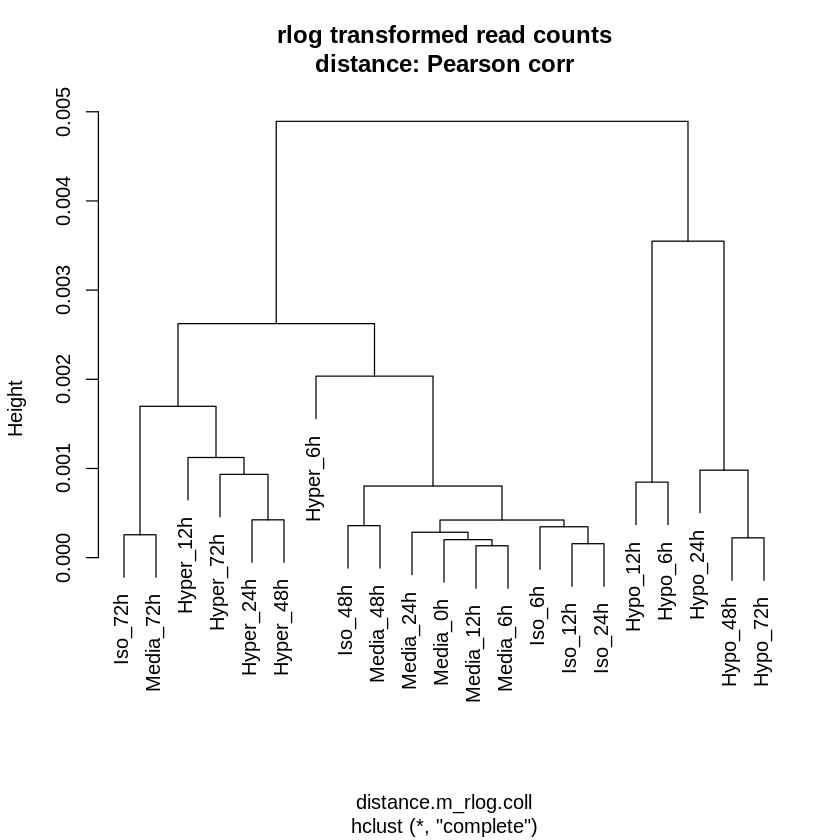

In [22]:
distance.m_rlog.coll <- as.dist(1 - cor(rlog.norm.counts.coll, method="pearson"))
plot(hclust(distance.m_rlog.coll), labels=colnames(rlog.norm.counts.coll), main = "rlog transformed read counts\ndistance: Pearson corr")

### Principal Components Analysis

Next we can perform Principal Components analysis to identify if groups of genes have something in common. This can be done most easily with `plotPCA()` function in `ggplot2` for a DESeq2

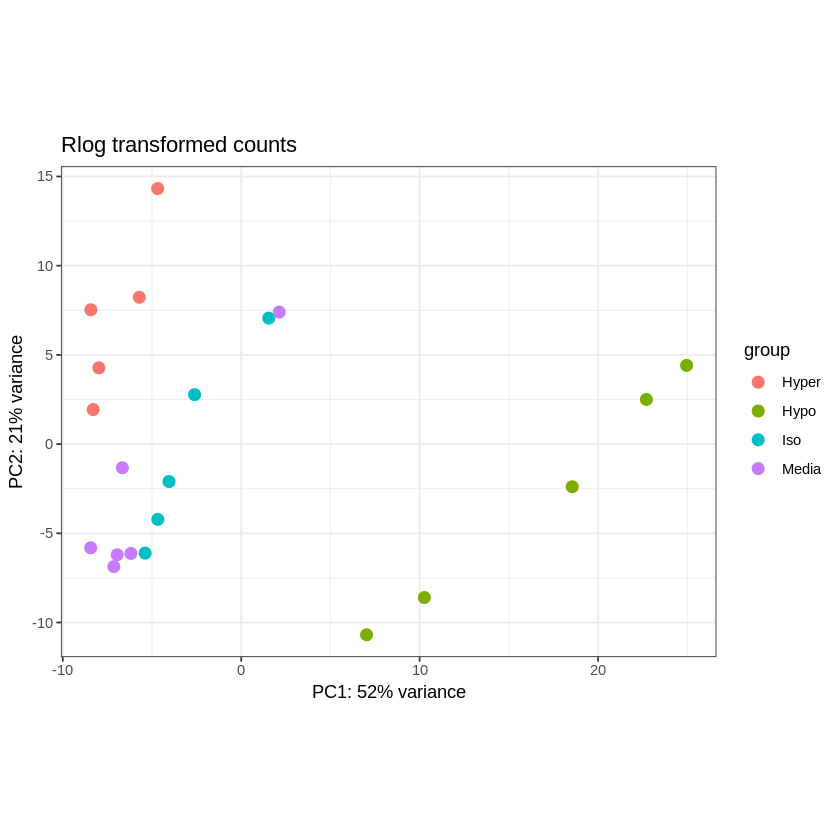

In [23]:
#Collapsed components
P.coll <- plotPCA(DESeq.rlog.coll, "Treatment")
P.coll <- P.coll + theme_bw() + ggtitle("Rlog transformed counts")
print(P.coll)

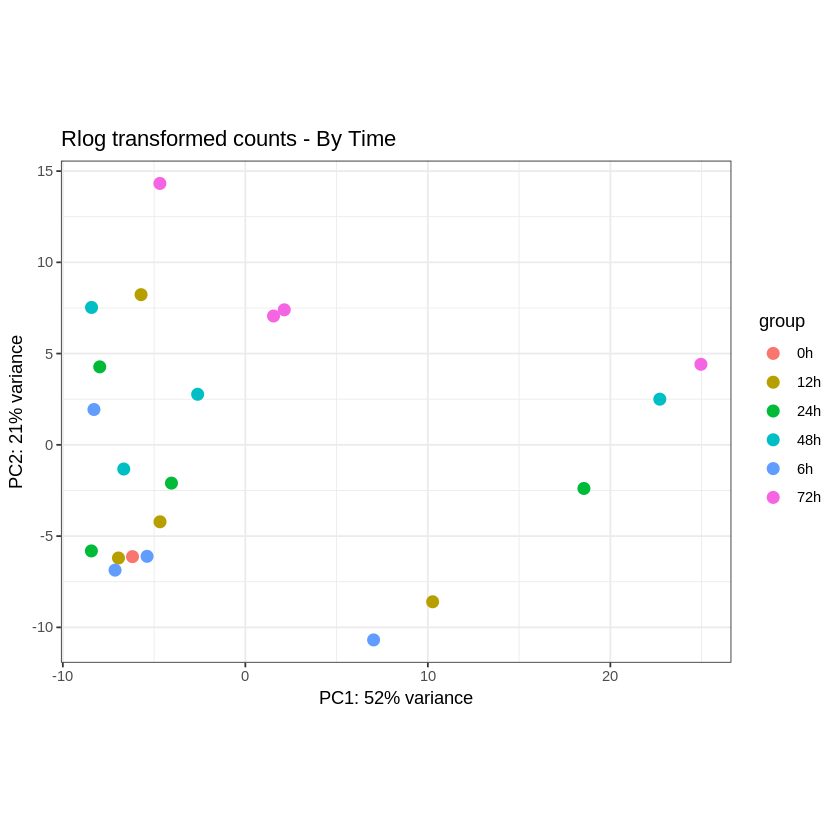

In [24]:
#PCA by time
#Collapsed components
P.coll.time <- plotPCA(DESeq.rlog.coll, "Time")
P.coll.time <- P.coll.time + theme_bw() + ggtitle("Rlog transformed counts - By Time")
print(P.coll.time)

### Differential Gene Expression Analysis

Next we will perform a differential gene expression analysis between different samples and time points to identify list of genes of interest. We will use the `limma` package for this. But first we need to get the proper list of gene symbols

To use the `limma` package we have to first create a design matrix for different sample conditions.

In [25]:
treatment <- factor(colData(DESeq.rlog.coll)[,1])
treatment

[1] Hyper Hyper Hyper Hyper Hyper Hypo  Hypo  Hypo  Hypo  Hypo  Iso   Iso  
[13] Iso   Iso   Iso   Media Media Media Media Media Media
Levels: Hyper Hypo Iso Media

In [26]:
timeinterval <- factor(colData(DESeq.rlog.coll)[,2])
timeinterval

[1] 12h 24h 48h 6h  72h 12h 24h 48h 6h  72h 12h 24h 48h 6h  72h 0h  12h 24h 48h
[20] 6h  72h
Levels: 0h 12h 24h 48h 6h 72h

In [27]:
design <- model.matrix(~treatment)
design.time <- model.matrix(~timeinterval)

Next we can use the `lmFit` function for the fitting and `eBayes` for making an adjustment to the p-values based on Bayes criteria

In [28]:
fit <- lmFit(rlog.norm.counts.coll, design)
fit <- eBayes(fit)
topTable(fit, coef=2, adjust="fdr", number=15)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
SULT1C2,1.0742645,3.107667,42.69572,2.270905e-19,4.120331e-15,32.06089
SMCO3,2.6705288,4.271397,26.42827,1.009646e-15,9.159506e-12,25.62794
ARRDC4,2.3257376,7.178200,21.74768,2.927424e-14,1.398710e-10,22.65086
SAP25,1.4338343,8.649229,21.68196,3.083576e-14,1.398710e-10,22.60357
SLC16A6,2.7239224,7.554396,20.07045,1.156849e-13,4.061454e-10,21.38827
SDSL,2.6604948,8.991761,19.89565,1.343073e-13,4.061454e-10,21.24968
MYCL,2.3611312,5.180822,19.70741,1.579415e-13,4.093844e-10,21.09888
OGA,1.4784577,12.460437,19.22658,2.405160e-13,5.454903e-10,20.70616
KIFC3,-0.6196548,12.580597,-18.89271,3.239211e-13,5.877424e-10,20.42693
RIMKLB,1.1876937,9.602819,18.84904,3.369041e-13,5.877424e-10,20.39000


We can get the full list of genes and write it to an output file for future analysis

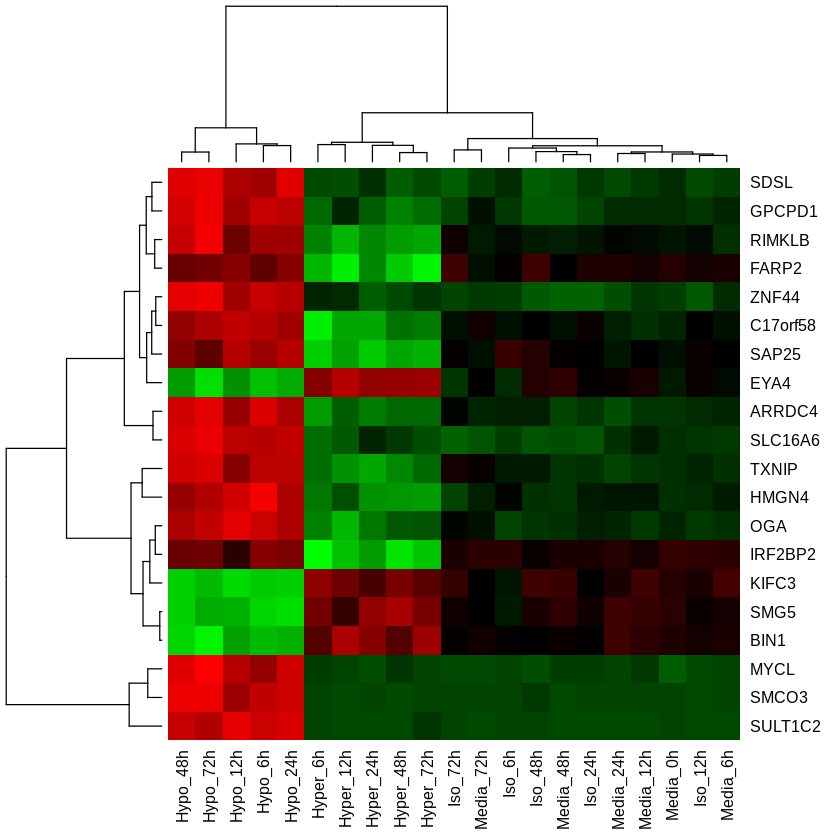

In [29]:
diffexpIDs <- as.character(rownames(topTable(fit, coef=2, number=20)))
diffexprows <- which(rownames(rlog.norm.counts.coll) %in% diffexpIDs)
heatmap(rlog.norm.counts.coll[diffexprows,], col=greenred(100), Rowv=F, scale="row", labCol=colnames(rlog.norm.counts.coll))

In [30]:
fit.time <- lmFit(rlog.norm.counts.coll, design.time)
fit.time <- eBayes(fit.time)
topTable(fit.time, coef=2, adjust="fdr", number=15)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
COL5A3,-0.50540596,4.5696554,-5.775256,3.027702e-05,0.4136213,1.37934641
LOC284898,-0.06160494,-1.6222767,-5.355074,6.803529e-05,0.4136213,0.86984262
CA2,-0.06098101,-1.6222767,-5.352415,6.838977e-05,0.4136213,0.86651472
FLJ20712,-0.17164638,1.1672927,-4.737872,2.325062e-04,0.9995744,0.06351506
EDARADD,-0.08957431,-0.8153277,-4.018042,1.022954e-03,0.9995744,-0.95532761
SLC24A5,-0.11153128,-0.3462480,-3.985657,1.094420e-03,0.9995744,-1.00282761
SLC23A1,-0.06575288,-1.2100798,-3.970930,1.128570e-03,0.9995744,-1.02446834
BTLA,-0.08977437,-0.4747555,-3.873732,1.382640e-03,0.9995744,-1.16789049
BHLHA15,-0.26457929,2.1497676,-3.749752,1.792294e-03,0.9995744,-1.35221410
FOLR1,-0.07798853,-0.7389603,-3.705433,1.966713e-03,0.9995744,-1.41844126


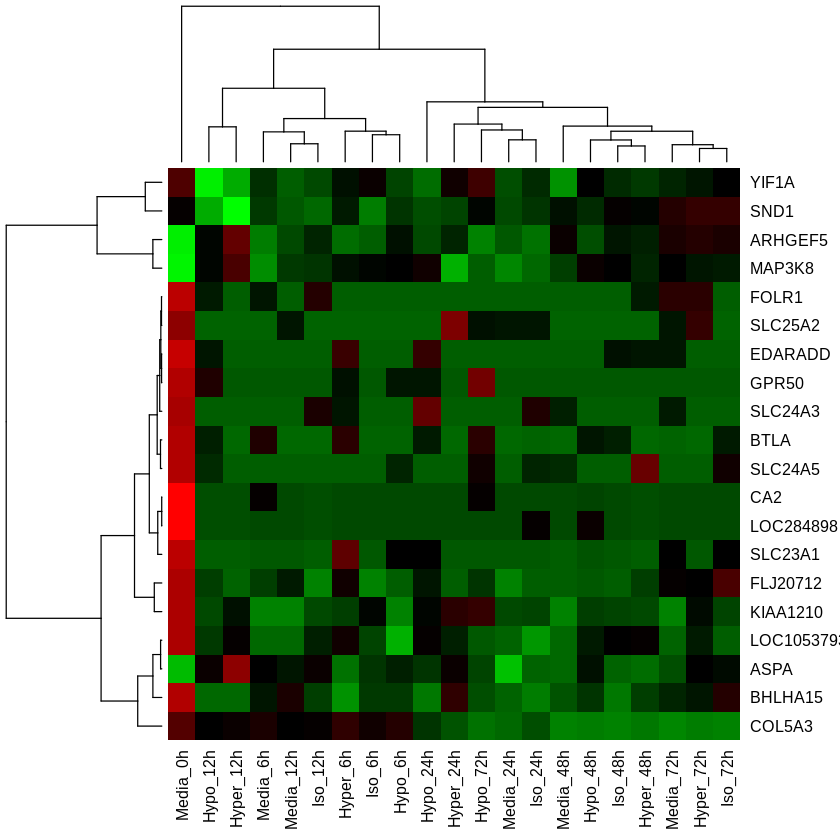

In [31]:
diffexpIDs.time <- as.character(rownames(topTable(fit.time, coef=2, number=20)))
diffexprows.time <- which(rownames(rlog.norm.counts.coll) %in% diffexpIDs.time)
heatmap(rlog.norm.counts.coll[diffexprows.time,], col=greenred(100), Rowv=F, scale="row", labCol=colnames(rlog.norm.counts.coll))